# RAG

## 环境准备

In [1]:
from Utils import gpt35, gpt4, tongyi, langchain_docs_extractor, WebPageObj

RUNNABLE_BASE_URL:  http://localhost:8000


In [ ]:
gpt35("""我在jupyterlab中无法加载修改过的python代码，是有缓存吗？""")

## 从langchain官网收集文档

<div class="alert alert-warning">
<b>兼容性问题：</b><br/>
    较新的BeautifulSoup版本是4.12.3，与python3.10兼容性较好，无法适应3.9或3.12，否则无法找到lxml或html5lib。
</div>

In [2]:
from bs4 import BeautifulSoup, SoupStrainer
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader
from langchain_community.document_loaders.sitemap import SitemapLoader
from langchain_core.utils.html import PREFIXES_TO_IGNORE_REGEX, SUFFIXES_TO_IGNORE_REGEX
import re

In [3]:
# 仅在jupyter中需要
import nest_asyncio
nest_asyncio.apply()

### 提取langchain的Docs文档

In [7]:
def metadata_extractor(meta: dict, soup: BeautifulSoup) -> dict:
    title = soup.find("title")
    description = soup.find("meta", attrs={"name": "description"})
    html = soup.find("html")
    return {
        "source": meta["loc"],
        "title": title.get_text() if title else "",
        "description": description.get("content", "") if description else "",
        "language": html.get("lang", "") if html else "",
        **meta,
    }

def load_langchain_docs():
    return SitemapLoader(
        "https://python.langchain.com/sitemap.xml",
        filter_urls=["https://python.langchain.com/"],
        parsing_function=langchain_docs_extractor,
        default_parser="lxml",
        bs_kwargs={
            "parse_only": SoupStrainer(
                name=("article", "title", "html", "lang", "content")
            ),
        },
        meta_function=metadata_extractor,
    ).load()

In [5]:
langchain_docs = load_langchain_docs()

Fetching pages: 100%|##########| 1180/1180 [07:51<00:00,  2.50it/s]


### 提取langchain的API文档

In [8]:
def simple_extractor(html: str) -> str:
    soup = BeautifulSoup(html, "lxml")
    return re.sub(r"\n\n+", "\n\n", soup.text).strip()

def load_api_docs():
    return RecursiveUrlLoader(
        url="https://api.python.langchain.com/en/stable/langchain_api_reference.html",
        max_depth=8,
        extractor=simple_extractor,
        prevent_outside=True,
        use_async=True,
        timeout=600,
        # Drop trailing / to avoid duplicate pages.
        link_regex=(
            f"href=[\"']{PREFIXES_TO_IGNORE_REGEX}((?:{SUFFIXES_TO_IGNORE_REGEX}.)*?)"
            r"(?:[\#'\"]|\/[\#'\"])"
        ),
        check_response_status=True,
        exclude_dirs=(
            "https://api.python.langchain.com/en/latest/_sources",
            "https://api.python.langchain.com/en/latest/_modules",
        ),
    ).load()

In [9]:
api_docs = load_api_docs()

### 提取langsmith的docs文档

In [8]:
def load_langsmith_docs():
    return RecursiveUrlLoader(
        url="https://docs.smith.langchain.com/",
        max_depth=8,
        extractor=simple_extractor,
        prevent_outside=True,
        use_async=True,
        timeout=600,
        # Drop trailing / to avoid duplicate pages.
        link_regex=(
            f"href=[\"']{PREFIXES_TO_IGNORE_REGEX}((?:{SUFFIXES_TO_IGNORE_REGEX}.)*?)"
            r"(?:[\#'\"]|\/[\#'\"])"
        ),
        check_response_status=True,
    ).load()

In [13]:
langsmith_docs = load_langsmith_docs()

/var/folders/f5/rlf27f4n6wzc_k4x7y4vzm5h0000gn/T/ipykernel_31512/320920142.py:2: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  soup = BeautifulSoup(html, "lxml")
/Users/xuehongwei/.pyenv/versions/3.10.0/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="

### 入库到duckdb

In [6]:
web_store = WebPageObj(db_name = "data/langchain.duckdb")

In [10]:
# https://python.langchain.com/
for d in langchain_docs:
    print(".", end = "")
    web_store.upsert(d, topic = "langchain_docs")

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [12]:
web_store.upsert(api_docs[0], topic = "langchain_api_docs")

In [17]:
# https://docs.smith.langchain.com/
for d in langsmith_docs:
    print(".", end = "")
    web_store.upsert(d, topic = "langsmith_docs")

.....................................................................

### 直接使用正则表达式匹配查询

In [15]:
docs = web_store.read_data(topic = "langchain_docs")

In [48]:
result = [obj for obj in docs if re.compile('lancedb', re.IGNORECASE).search(obj.source)]
for obj in result:
    print(obj.source)

https://python.langchain.com/docs/integrations/providers/lancedb
https://python.langchain.com/docs/integrations/vectorstores/lancedb


### 将文本向量入库lancedb

#### 加载文本向量

In [2]:
langchain_web = WebPageObj(db_name = "data/langchain.duckdb")
docs = langchain_web.read_data(topic = None)

#### 观察文本数据特征

<div class="alert alert-success">
<b>观察文本大小：</b><br/>
    有很多文档的尺寸超过了50K，最大的达到200K。<br>
    其中，主要是因为包含了图片的base64编码。
</div>

In [3]:
dict_list = [{ "source": obj.source, "len": len(obj.page_content) } for obj in docs]
sorted_dict_list = sorted(dict_list, key = lambda x: x['len'], reverse = True)
for obj in sorted_dict_list:
    print(obj['len'], " >> ", obj['source'])

195919  >>  https://python.langchain.com/docs/integrations/retrievers/activeloop
150150  >>  https://python.langchain.com/docs/use_cases/question_answering/citations
74417  >>  https://python.langchain.com/docs/integrations/document_loaders/dropbox
73698  >>  https://python.langchain.com/docs/integrations/vectorstores/timescalevector
66009  >>  https://python.langchain.com/docs/integrations/document_loaders/docugami
65474  >>  https://python.langchain.com/docs/use_cases/code_understanding
63441  >>  https://python.langchain.com/docs/integrations/tools/google_lens
62074  >>  https://python.langchain.com/docs/integrations/chat/ollama
60867  >>  https://python.langchain.com/docs/expression_language/cookbook/prompt_size
59026  >>  https://python.langchain.com/docs/guides/debugging
57438  >>  https://python.langchain.com/docs/integrations/llms/ollama
54666  >>  https://api.python.langchain.com/en/stable/langchain_api_reference.html
53959  >>  https://python.langchain.com/docs/modules/agents

<div class="alert alert-success">
<b>下面对文本内容做瘦身：</b><br/>
    1、删除图像编码。<br>
    2、删除示例脚本中的输出内容。
</div>

In [4]:
import re
# 移除base64编码
def remove_base64(content):
    pattern = r'base64,(?:(?:[A-Za-z0-9+/]{4})*(?:[A-Za-z0-9+/]{2}==|[A-Za-z0-9+/]{3}=)?)'
    return re.sub(pattern, '', content)

# 移除示例代码中的输出结果
def remove_text_blocks(content):
    pattern = r'```text\r?\n.*?\r?\n```'
    return re.sub(pattern, '', content, flags=re.DOTALL)

def search_by_source(keywords):
    result = [obj for obj in docs if re.compile(keywords, re.IGNORECASE).search(obj.source)]
    page_contents = []
    for obj in result:
        page_contents.append(obj.page_content)
    return page_contents

In [16]:
langchain_new_docs = [(remove_text_blocks(remove_base64(obj.page_content)), obj.source) for obj in docs]
dict_list = [{"source": source, "content": content, "len": len(content)} for content, source in langchain_new_docs]
newDocs = sorted(dict_list, key = lambda x: x['len'], reverse = True)
for obj in newDocs:
    print(obj['len'], " >> ", obj['source'])

54666  >>  https://api.python.langchain.com/en/stable/langchain_api_reference.html
30920  >>  https://python.langchain.com/docs/integrations/vectorstores/timescalevector
29616  >>  https://python.langchain.com/docs/modules/data_connection/document_loaders/file_directory
28836  >>  https://docs.smith.langchain.com/tracing/tracing-faq
28812  >>  https://python.langchain.com/docs/integrations/tools/google_lens
26134  >>  https://python.langchain.com/docs/langgraph
24125  >>  https://python.langchain.com/docs/langserve
23943  >>  https://docs.smith.langchain.com/evaluation/quickstart
23617  >>  https://python.langchain.com/docs/integrations/toolkits/github
22722  >>  https://python.langchain.com/docs/integrations/vectorstores/redis
22675  >>  https://python.langchain.com/docs/guides/safety/amazon_comprehend_chain
22587  >>  https://docs.smith.langchain.com/cookbook/testing-examples/comparing-runs
22480  >>  https://python.langchain.com/docs/get_started/quickstart
22014  >>  https://python.

Activeloop Deep Memory | 🦜️🔗 Langchain

[Skip to main content](#__docusaurus_skipToContent_fallback)# Activeloop Deep Memory

[Activeloop Deep
Memory](https://docs.activeloop.ai/performance-features/deep-memory)
is a suite of tools that enables you to optimize your Vector Store for
your use-case and achieve higher accuracy in your LLM apps.

`Retrieval-Augmented Generatation` (`RAG`) has recently gained
significant attention. As advanced RAG techniques and agents emerge,
they expand the potential of what RAGs can accomplish. However, several
challenges may limit the integration of RAGs into production. The
primary factors to consider when implementing RAGs in production
settings are accuracy (recall), cost, and latency. For basic use cases,
OpenAI’s Ada model paired with a naive similarity search can produce
satisfactory results. Yet, for higher accuracy or recall during
searches, one might need to employ advanced retrieval techniques. These
methods might involve varying data chunk siz
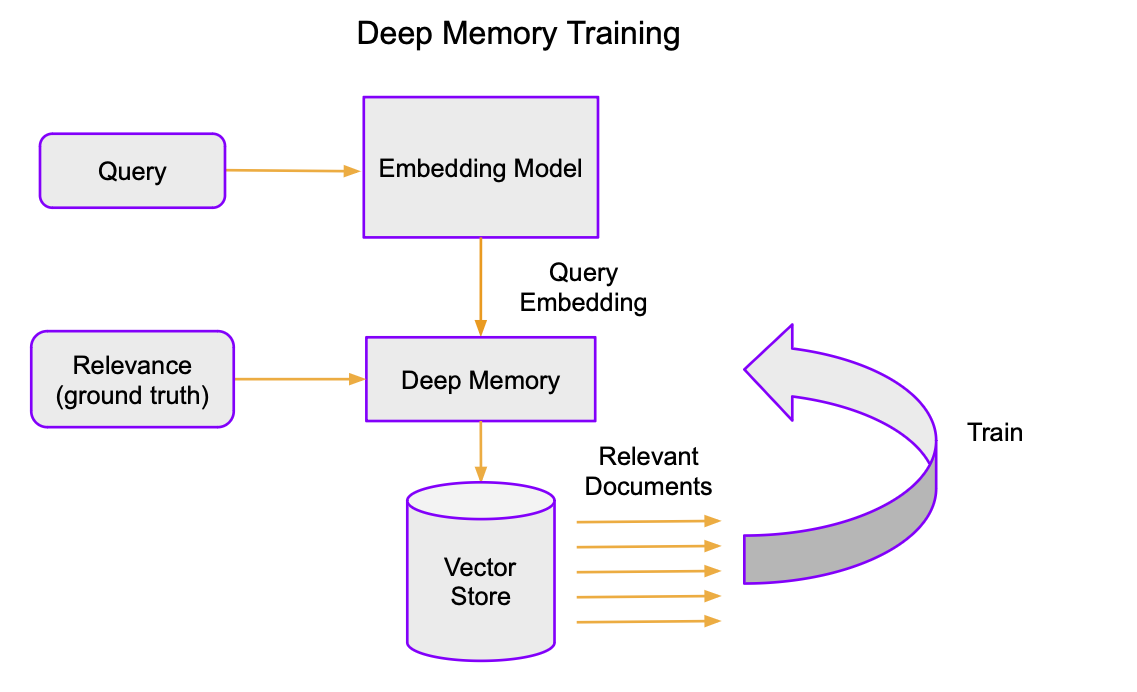
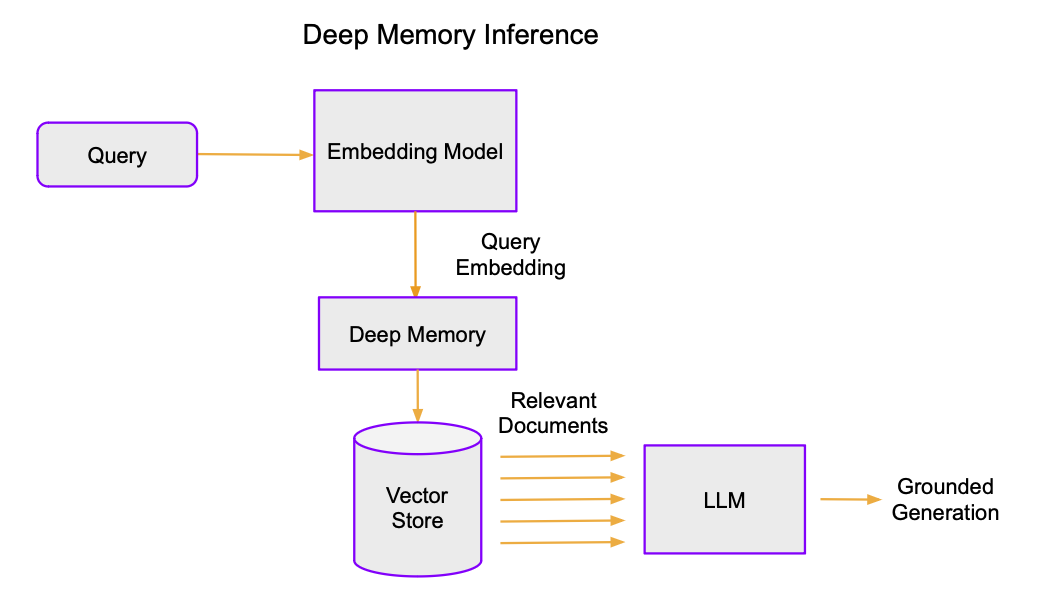

In [10]:
content = search_by_source('integrations/retrievers/activeloop')
for obj in content:
    print(remove_text_blocks(obj))

In [15]:
content = search_by_source('question_answering/citations')
for obj in content:
    res = remove_text_blocks(remove_base64(obj))
    print("length:", len(res), ">> \n\n")
    print(res)

length: 15343 >> 


Citations | 🦜️🔗 Langchain

[Skip to main content](#__docusaurus_skipToContent_fallback)# Citations

How can we get a model to cite which parts of the source documents it
referenced in its response?

To explore some techniques for extracting citations, let’s first create
a simple RAG chain. To start we’ll just retrieve from Wikipedia using
the
[WikipediaRetriever](https://api.python.langchain.com/en/latest/retrievers/langchain_community.retrievers.wikipedia.WikipediaRetriever.html).

## Setup​

First we’ll need to install some dependencies and set environment vars
for the models we’ll be using.

```python
%pip install -qU langchain langchain-openai langchain-anthropic langchain-community wikipedia
```

```python
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass()
os.environ["ANTHROPIC_API_KEY"] = getpass.getpass()

# Uncomment if you want to log to LangSmith
# os.environ["LANGCHAIN_TRACING_V2"] = "true
# os.environ["LANGCHAIN_API_KEY"] = getpas

#### 切分字符串

In [17]:
len(langchain_new_docs)

1250